# Open-loop control and receding-horizon control
In this tutorial we demonstrate how to use CVXPY to solve optimizazion problems. And will compare open-loop control and receding-horizon control.

We have a system with a state $x_k\in {\mathbb R}^{n_x}$, inputs $u_k\in {\mathbb R}^{n_u}$, and the following LTI dynamics:

$$ x_{k+1} = A\, x_k + B \,u_k  = \left[\begin{smallmatrix} 0.15 & 0 \\ 0 & 0.85 \end{smallmatrix}\right] x_k + \left[\begin{smallmatrix}  0.1 & 0\\ 0 & 1\end{smallmatrix}\right] u_k.$$

Our goal is to find the optimal control actions $u_0,\ldots,u_{K-1}$ by solving the optimization problem

\begin{array}{ll} \mbox{minimize} & \sum_{k=0}^{K-1} q \, \| x_k\|_2^2 + r \, \| u_k\|_2^2\\
\mbox{subject to} & x_{k+1} = Ax_k + Bu_k\\%, \quad k=0, \ldots, K-1\\
& \| u_k\|_{\infty}\leq 3, \quad x_K= 0,
%, \quad \quad k=0, \ldots, K
\end{array}

where $q  = 0.1 $ and $ r = 1$ are constant cost weights on the state and input.

### Convexity
CVXPY can only be used to solve convex optimization problem. Remember an optimization problem is convex if it fulfills the following criteria:
 the costs and constraints are convex.

* The cost function is convex
* The inequallity constraints form convex sets
* The eqauility constraints are affine

See the Definition on page 136 & 137 in *\[S. Boyd and L. Vandenberghe, 'Convex Optimization', 2004\]*.


**Question 1:**


Is the optimization problem above convex?

**Answer 1:**

Yes, because
* The cost is a quadratic function which is convex.
* The inequality constraint function is the infinity norm which is convex.
* The dynamic constraint and terminal state constraint are affine.

In [ ]:
# Generate data for control problem.
import numpy as np

n_x,n_u = 2,2   # state and input dimension

K = 6   # prediction horizon

x_0 = np.array([-6,-3])

A = np.array([[0.15,0], [0,0.85]])
B = np.array([[0.1,0],[0, 1]])
q = 0.1
r = 1

## Open-loop control
Fill out the blanks below to construct the optimization problem in CVXPY. You can use the different atom functions of CVXPY listed [here](https://www.cvxpy.org/api_reference/cvxpy.atoms.html).

In [ ]:
# Form and solve the control problem.
import cvxpy as cp


x = cp.Variable((n_x, K + 1))
u = cp.Variable((n_u, K))

cost = 0
constr = []
# Sum problem objectives and concatenate constraints.

for k in range(K):
    cost +=  q*cp.sum_squares(x[:, k]) + r*cp.sum_squares(u[:, k])
    constr += [x[:, k + 1] == A @ x[:, k] + B @ u[:, k], cp.norm(u[:, k], "inf") <= 3]

# Add initial and terminal state constraint
constr += [x[:, K] == 0, x[:, 0] == x_0]
problem = cp.Problem(cp.Minimize(cost), constr)
problem.solve()


5.904559632010684

Text(0.5, 1.0, 'Open-loop simulation')

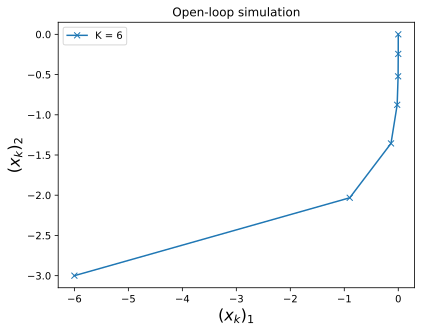

In [ ]:
# Plot results.
import matplotlib.pyplot as plt
#plt.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'svg'

f1 = plt.figure()

plt.plot(x[0,:].value, x[1,:].value, marker = 'x')

plt.xlabel("$(x_k)_1$", fontsize=16)
plt.ylabel("$(x_k)_2$", fontsize=16)
plt.legend(['K = ' + str(K)])
plt.title('Open-loop simulation')

**Question 2:**

Is the terminal state zero? If not, why is this the case?

In [ ]:
# TODO: Print terminal state and check if it is zero
# You can access the value of a variable in cvxpy by adding .value
print(x[:,K].value)

[-1.11225355e-13 -1.43306370e-10]


**TODO:** Solve the same optimization problem again but increase the precision of the solver such that the terminal state is closer to zero.

In [ ]:
# TODO: Solve problem again and print terminal state with higher precision
problem.solve(solver=cp.SCS, eps=1e-10)
print(x[:,K].value)

[-2.80563656e-13  3.72488124e-17]


**Answer 2:**


Even with a zero terminal state constraint, the value will never be exactly zero, but by increasing the precision it gets arbitrarily close to zero.
Every solver has a solver precision which can be set in CVXPY. Increasing the precision comes at a higher computational cost especially in large dimensional problems, i.e., the solver requires more iteratios to solve the problem.
Depending on the specific application, a more or less precise solution is desirable. In some applications decreasing precision might even be required to reduce computational load, for example in an embedded controller on a small quadrotor such as the [crazyfly](https://en.wikipedia.org/wiki/Crazyflie_2.0).  Before solving an optimization problem as a control engineer we need to think about the numerical and computational requirements of the machine, plant, device etc. that we want to control.  



## Open-loop control: Comparing horizon length

The prediciton horizon length has a significant impact on the trajectory both in open and closed-loop control.

Text(0.5, 1.0, 'Open-loop: Comparison horizon length')

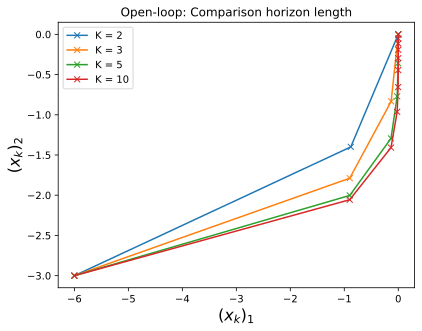

In [ ]:
#%% Open loop comparing horizon length

K_all = [2,3, 5, 10]

f2 = plt.figure()

for K in K_all:

    x = cp.Variable((n_x, K + 1))
    u = cp.Variable((n_u, K))

    cost = 0
    constr = []
    for k in range(K):
        cost +=  q*cp.sum_squares(x[:, k]) + r*cp.sum_squares(u[:, k])
        constr += [x[:, k + 1] == A @ x[:, k] + B @ u[:, k], cp.norm(u[:, k], "inf") <= 3]
    # sums problem objectives and concatenates constraints.
    constr += [x[:, K] == 0, x[:, 0] == x_0]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve()

    plt.plot(x[0,:].value, x[1,:].value, marker = 'x' )

plt.xlabel("$(x_k)_1$", fontsize=16)
plt.ylabel("$(x_k)_2$", fontsize=16)
plt.legend(['K = 2','K = 3', 'K = 5', 'K = 10'])
plt.title('Open-loop: Comparison horizon length')

**Question 3:**

Why does the state trajectory change with the horizon length? Explain why the state follows the trajectory above for K=10? Why is that cost optimal? You can also inspect the input trajectory using the code below to support your explanation .


**Answer 3:**

All of the optimization problems have a terminal state constraint. With a longer horizon length there are more steps available to reach the terminal state. In this example the weight on the state $q = 0.1$ is much smaller than the weight on the input $r= 1$. So it is more cost optimal to apply a small input at every time step and converge slowly to the zero state rather than applying large inputs, especially with a an input cost as the 2-norm squared, i.e., $ r \|u_k\|_2^2$ and stable open-loop dynamics which will lead to the system converging to zero over time even with little input appplied. So the system dynamics are doing "more of the job" regulating it to zero than the control. This is confirmed when plotting the input sequences for different horizon lengths.






Text(0, 0.5, '$(u_t)_2$')

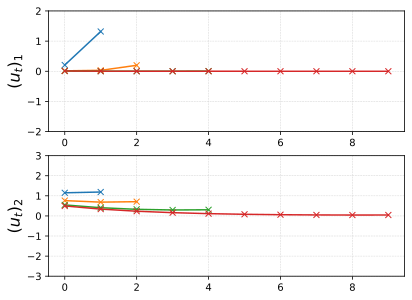

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1)
K_all = [2,3, 5, 10]

for K in K_all:

    x = cp.Variable((n_x, K + 1))
    u = cp.Variable((n_u, K))

    cost = 0
    constr = []
    for k in range(K):
        cost +=  q*cp.sum_squares(x[:, k]) + r*cp.sum_squares(u[:, k])
        constr += [x[:, k + 1] == A @ x[:, k] + B @ u[:, k], cp.norm(u[:, k], "inf") <= 3]
    # sums problem objectives and concatenates constraints.
    constr += [x[:, K] == 0, x[:, 0] == x_0]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve()

    axs[0].plot(u[0, :].value, marker = 'x')
    axs[1].plot(u[1, :].value, marker = 'x')


axs[0].set_ylim([-2,2])
axs[0].grid(which='both', axis='both',color='lightgrey', linestyle='--', linewidth=0.5)
axs[0].set_ylabel(r"$(u_t)_1$", fontsize=16)

axs[1].set_ylim([-3,3])
axs[1].grid(which='both', axis='both', color='lightgrey', linestyle='--', linewidth=0.5)
axs[1].set_ylabel(r"$(u_t)_2$", fontsize=16)


We see from the input plots that with a longer horizon the control effort is lower and it "more equally distributed" over the horizon which for a quadratic cost is optimal.

## Feasibility
Solve the control problem again for a horizon length of 1.

In [ ]:
K = 1
x = cp.Variable((n_x, K + 1))
u = cp.Variable((n_u, K))

cost = 0
constr = []
for k in range(K):
    cost +=  q*cp.sum_squares(x[:, k]) + r*cp.sum_squares(u[:, k])
    constr += [x[:, k + 1] == A @ x[:, k] + B @ u[:, k], cp.norm(u[:, k], "inf") <= 3]
# sums problem objectives and concatenates constraints.
constr += [x[:, K] == 0, x[:, 0] == x_0]
problem = cp.Problem(cp.Minimize(cost), constr)
problem.solve(verbose=True)

problem.status

                                     CVXPY                                     
                                     v1.3.3                                    
(CVXPY) Mar 15 02:18:05 PM: Your problem has 6 variables, 4 constraints, and 0 parameters.
(CVXPY) Mar 15 02:18:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 15 02:18:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 15 02:18:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 15 02:18:05 PM: Compiling problem (target solver=OSQP).
(CVXPY) Mar 15 02:18:05 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing 

'infeasible'

**Question 4:**

Why is the ouput of the cvxpy problem infeasible?

**Answer 4:**

With the LTI dynamics and the input constraints it is not possible to reach the terminal state zero within one time step. This can also be verified by hand caluclation. Infeasibility of an optimization problem occurs if there is no solution, independent of its cost, that can jointly fulfill all the constraints. In this case here, the combination of dynamic, input and terminal constraints makes the problem infeasible.

# Receding-horizon control

Implement the same control problem above now in a receding-horizon fashion. This encompasses three important steps:

1. Solve open-loop problem for x_0
2. Compute the state evolution by applying the first input of the optimal control sequence $x_{k+1} = A x_{k} + B u_{k} = A x_0 + B u^*_0$, this becomes the new intitial state
3. Save the new state in a state trajectory array.

Repeat $\forall t = 1, \dots, T$.

In [ ]:
%%html
<iframe src="https://drive.google.com/file/d/1U3F6pVWZQJ4RRe8Y7CA14EVRr5VLGZLK/preview" width="640" height="220" allow="autoplay"></iframe>

Text(0.5, 1.0, 'Closed-loop simulation')

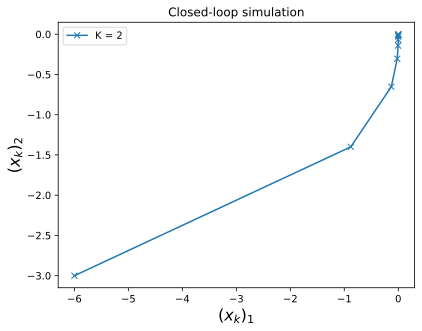

In [ ]:
T = 10  # control horizon
K = 2   # prediciton horizon

x_0 = np.array([-6,-3])

x_traj = np.zeros([n_x, T+1])
u_traj =  np.zeros([n_u, T])

x_traj[:, 0] = x_0

for t in range(T):

    x = cp.Variable((n_x, K + 1))
    u = cp.Variable((n_u, K))

    cost = 0
    constr = []
    for k in range(K):
        cost +=  q*cp.sum_squares(x[:, k]) + r*cp.sum_squares(u[:, k])
        constr += [x[:, k + 1] == A @ x[:, k] + B @ u[:, k], cp.norm(u[:, k], "inf") <= 3]
    # sums problem objectives and concatenates constraints.
    constr += [x[:, K] == 0, x[:, 0] == x_0]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve()

    x_0 = A @ x_0 + B @ u[:,0].value

    u_traj[:, t] = u[:,0].value
    x_traj[:, t+1] = x_0


f4 = plt.figure()

plt.plot(x_traj[0,:], x_traj[1,:], marker = 'x')

plt.plot()
plt.xlabel("$(x_k)_1$", fontsize=16)
plt.ylabel("$(x_k)_2$", fontsize=16)
plt.legend(['K = ' + str(K)])
plt.title('Closed-loop simulation')

## Closed-loop $\neq$ Open-loop


In general, in MPC even without noise and disturbances on the state. The closed-loop trajectory will in general not be equal to the predicted open-loop trajectory. Which is illustrated in the Figure below [*Basil Kouvaritakis and Mark Cannon, 'Model Predictive Control' , 2016, page 31*]:


In [ ]:
%%html
<iframe src="https://drive.google.com/file/d/1vylq7Fracv4Adl99OJXQBpCIZKZcli7w/preview" width="640" height="480" allow="autoplay"></iframe>

Let's investigate the difference between the open and closed-loop trajectories for different prediction horizon lengths.

Text(0.5, 1.0, 'Closed-loop simulation')

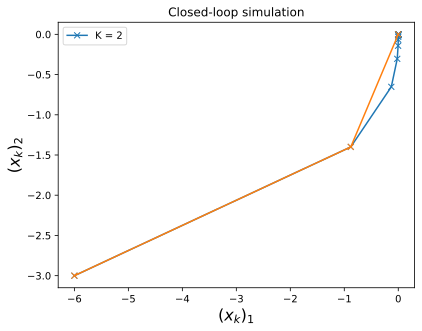

In [ ]:
T = 20  # control horizon
K = 2   # prediciton horizon, try K=2,5,10,20 what do you observe?

x_0 = np.array([-6,-3])

x_traj = np.zeros([n_x, T+1])
u_traj =  np.zeros([n_u, T])

x_traj[:, 0] = x_0

for t in range(T):

    x = cp.Variable((n_x, K + 1))
    u = cp.Variable((n_u, K))

    cost = 0
    constr = []
    for k in range(K):
        cost +=  q*cp.sum_squares(x[:, k]) + r*cp.sum_squares(u[:, k])
        constr += [x[:, k + 1] == A @ x[:, k] + B @ u[:, k], cp.norm(u[:, k], "inf") <= 3]
    # sums problem objectives and concatenates constraints.
    constr += [x[:, K] == 0, x[:, 0] == x_0]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve()

    if t == 0:
        x_open = x.value.copy()
        u_open = u.value.copy()

    x_0 = A @ x_0 + B @ u[:,0].value

    u_traj[:, t] = u[:,0].value
    x_traj[:, t+1] = x_0


f4 = plt.figure()

plt.plot(x_traj[0,:], x_traj[1,:], marker = 'x')
plt.plot(x_open[0,:], x_open[1,:], marker = 'x')

plt.plot()
plt.xlabel("$(x_k)_1$", fontsize=16)
plt.ylabel("$(x_k)_2$", fontsize=16)
plt.legend(['K = ' + str(K)])
plt.title('Closed-loop simulation')

**Question 5:**

Why does the closed-loop trajectory not match the initial open-loop prediction?

**Answer 5:**

In receding-horizon control only the first input of the optimal control sequence is applied. The dynamic system evolves and the horizon is shifted. From the new initial state the problem is solved again for a horizon of K. So effectively there is one extra time step to reach the zero terminal state and as we saw before (comparison open-loop horizon length) with an additional time step a different trajectory is improving the cost.

**Question 6:**

What happens if the prediction horizon gets longer and longer? Check this in your simulation. Why does this happen?

**Answer 6:**

The longer the prediciton horizon the more the open- and closed-loop trajectories will coincide as the extra step does not change the trajectory much anymore and both of them become a close approximation to the infinite horizon controller.